# Initial visualization of CYGNSS watermask
## Environments and packages
Chose to use xarray package, not netCDF4, to read the data, so I can view, manipulate, and analyze the data within xarray. I could not use a custom conda environment within Savio Jupyter notebooks, so I am using the base environment with xarray `pip install`ed in my home directory.

Use xarray v0.18.0, but cannot use a conda environment to set this because I don't understand Savio.

## Directory structure
I am reading CYGNSS watermasks from Cynthia's Savio scratch account. There is a 0.01$^\circ$ format and a 0.5$^\circ$ format. For my purposes, I want to always use the 'with_lakes' version. The 0.5$^\circ$ version is a single .nc file while the 0.01$^\circ$ version is a separate .nc file for each month.

# Reading Data 0.5$^\circ$
## Data description 0.5$^\circ$
- Monthly data from 2018-08 to 2022-04 (inclusive)
- xarray indexing order: [lat,lon,time]
- single .nc file

In [1]:
# !pip install xarray --user
import sys
# sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/xarray')
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cygnss_filename = 'CYGNSS_watermask_0_5_with_lakes.nc'
cygnss_filepath = '/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/WetCHARTs_size_0_5_deg/'

In [3]:
cygnss_raw = xr.open_dataset(cygnss_filepath+cygnss_filename, decode_times=False)
fw=cygnss_raw['fw']
fw

<xarray.DataArray 'fw' (lat: 151, lon: 721, time: 57)>
[6205647 values with dtype=float32]
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 52.0 53.0 54.0 55.0 56.0
  * lat      (lat) float32 -37.5 -37.0 -36.5 -36.0 -35.5 ... 36.0 36.5 37.0 37.5
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Attributes:
    long_name:  Monthly fractional surface water (0-100)
    units:      percent water

## Sample map for a single time

In [6]:
cygnss_raw

<xarray.Dataset>
Dimensions:  (time: 57, lat: 151, lon: 721)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 52.0 53.0 54.0 55.0 56.0
  * lat      (lat) float32 -37.5 -37.0 -36.5 -36.0 -35.5 ... 36.0 36.5 37.0 37.5
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Data variables:
    fw       (lat, lon, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Text(0, 0.5, 'Latitude ($^\\circ$)')

<Figure size 640x480 with 0 Axes>

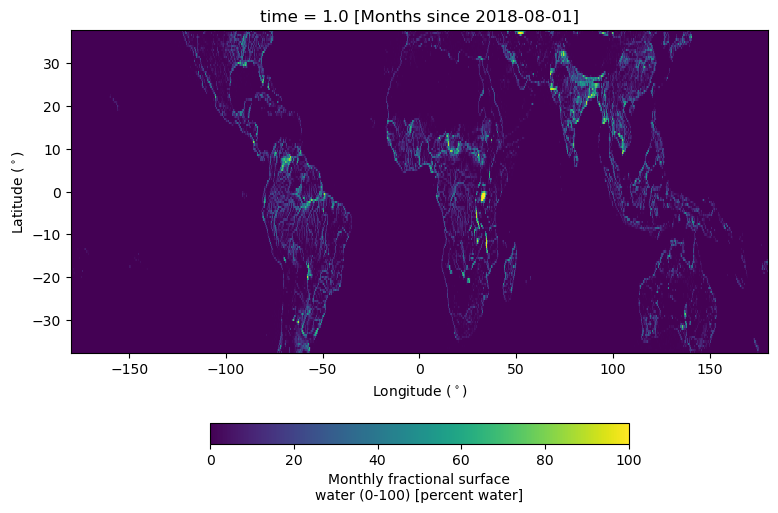

In [25]:
sep2018 = fw[:,:,1]
fig = plt.figure()
ax = sep2018.plot(figsize=(9,6),cbar_kwargs={"orientation": "horizontal",
                                             "shrink":0.6})
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')

## Sample time series for a single pixel

In [5]:
merowe = (18.68 , 32.06)
indirasagar = (22.18,76.6)

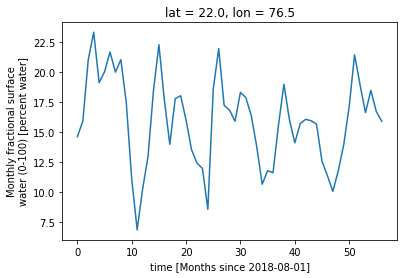

In [6]:
coords_i = (22.18,76.6) # (lat,lon) 
fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest').plot()

## Time coordinate mainpulations

# Reading data 0.01$^\circ$

## Data loading
Successfully made loading functions to read and combine multiple months of data for a given bounding box.
## Data description 0.01$^\circ$
- native resolution
- Monthly data from 2018-08 to 2022-04 (inclusive)
- one .nc file per month

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
import os

In [3]:
cygnss_filepath = '/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
cygnss_filenames = os.listdir(cygnss_filepath)
cygnss_filenames.sort()

## Base loading and manipulation
Using xarray functions, with no pre-loaded/fucntionalized manipulations

In [4]:
test_1month = xr.open_dataset(cygnss_filepath+cygnss_filenames[0], decode_times=False)
fw=test_1month['Watermask']
fw

<xarray.DataArray 'Watermask' (lat: 7481, lon: 36001)>
[269323481 values with dtype=int8]
Coordinates:
  * lat      (lat) float32 -37.4 -37.39 -37.38 -37.37 ... 37.37 37.38 37.39 37.4
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:  UCBerkeley_RW_CYGNSS-based watermask for 2018_08
    units:      Land = 1, Surface water = 2, Ocean = 3, No data = 4
    comments:   Values ranges from 1-4, where Land = 1, Surface water = 2, Oc...

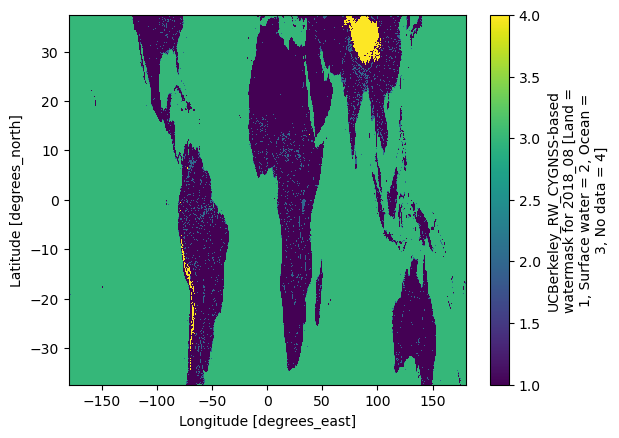

In [9]:
fw.plot()

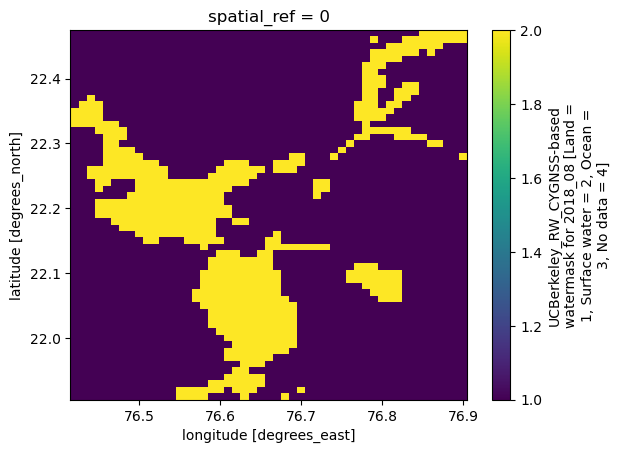

In [7]:
test_rxr = fw.rio.write_crs(4326)
test_rxr.rio.set_spatial_dims('lon','lat',inplace=True)
test_boxclip = test_rxr.rio.clip_box(76.42467457600003, 21.907250000000033, 76.90174206500012, 22.4733543750001)
test_boxclip.plot()

## Loading functions

Creating and testing functions for loading native-res CYGNSS maps. Once made, these functions are added to `load_data.py`.

In [4]:
def read_CYGNSS_01_1month(filename,
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    global_xrDS = xr.open_dataset(filepath+filename, decode_times=False)
    global_rxr = global_xrDS['Watermask'].rio.write_crs(4326)
    del global_xrDS
    global_rxr.rio.set_spatial_dims('lon','lat',inplace=True)
    clipped_rxr = global_rxr.rio.clip_box(*bbox_vals)
    del global_rxr
    return clipped_rxr

In [5]:
def read_CYGNSS_all_months(
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    filenames = os.listdir(filepath)
    filenames.sort()
    list_of_xr = [read_CYGNSS_01_1month(filename,test_bbox) for filename in filenames]
    time_idx = np.arange(len(filenames))
    cygnss_allmonths_xr = xr.concat(list_of_xr,pd.Index(time_idx , name='time'),combine_attrs="drop_conflicts")
    return cygnss_allmonths_xr

In [6]:
def CYGNSS_1month_plot(filename,
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    clipped_rxr = read_CYGNSS_01_1month(filename,bbox_vals,filepath)
    clipped_rxr.plot()
    return clipped_rxr

In [7]:
test_bbox = (76.42467457600003, 21.907250000000033, 76.90174206500012, 22.4733543750001)

In [13]:
test_allmonths = read_CYGNSS_all_months(test_bbox)

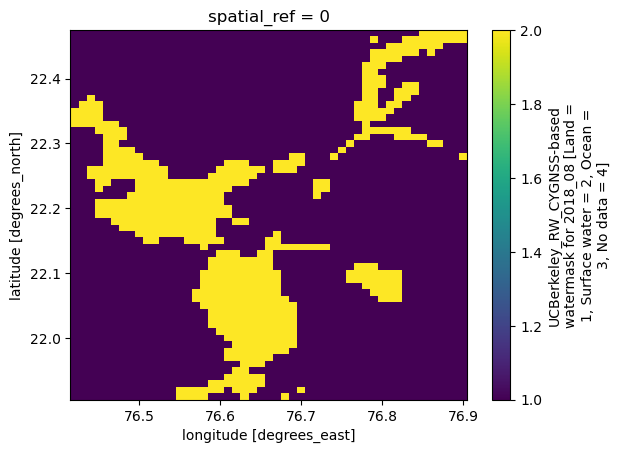

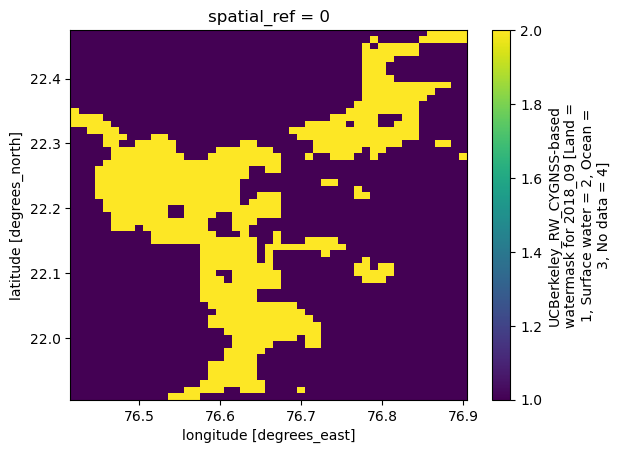

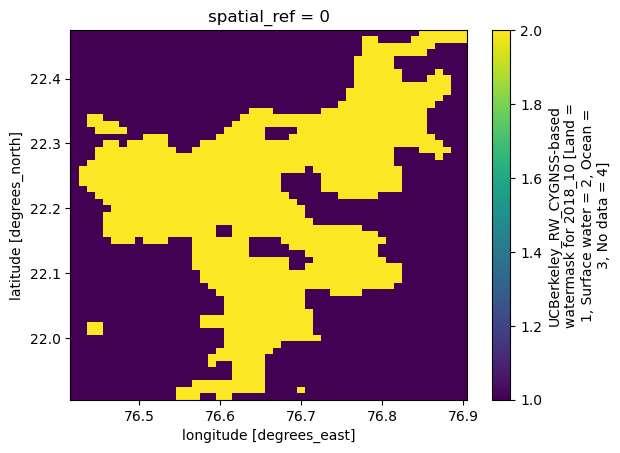

In [15]:
small_list = cygnss_filenames[:3]

# fig , ax = plt.subplots()
artists = []
for filename in small_list:
    plt.figure()
    test_month = CYGNSS_1month_plot(filename,test_bbox)

## Creating a custom colormap

In [3]:
from matplotlib import colors

In [4]:
color_array = [[0.5, 0.5, 0.5, 0],
              [0, 0, 1, 0.8]]
custom_cmap = colors.ListedColormap(colors=color_array)

In [5]:
# Does not work. Meant to add basemap to xarray plot.

# from mpl_toolkits.basemap import Basemap

# map = Basemap(llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, epsg=5520)
# #http://server.arcgisonline.com/arcgis/rest/services

# map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
# plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

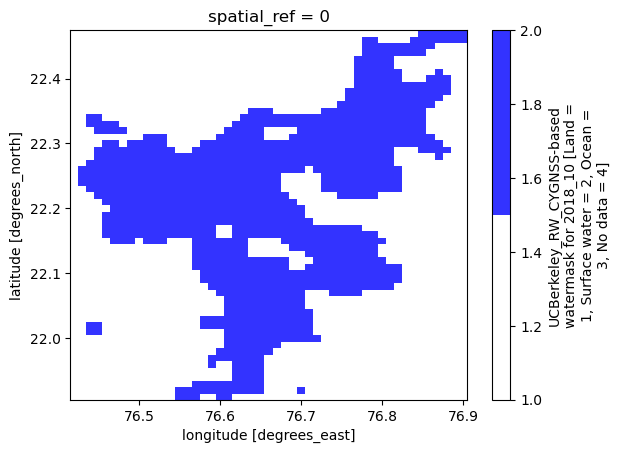

In [34]:
test_month.plot.imshow(cmap = custom_cmap)

## Convert CYGNSS categories to binary mask

Conversion to binary is functional.

In [72]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'
import sys
sys.path.append(func_dir)
import load_data

In [74]:
test_fw = load_data.load_CYGNSS_001_1month(cygnss_filenames[0],test_bbox)

In [75]:
def cygnss_convert_to_binary(cygnss_DA, true_val = 2):
    """
    Convert categorical CYGNSS maps to binary int.

    Long Description
    ----------------
    Does not convert from int to bool because some manipulations and calculations require numeric data.
    Due to limited xarray-compatible fucntions, uses a two-step process:
        first, converts non-surface water to 0,
        second converts remaining non-zero values to 1.
    The true_val cannot be zero.

    Inputs
    ------
    cygnss_DA : xarray.DataArray
        data array with values 1-4
    true_val : numeric
        default = 2
        the value to become True/1

    Outputs
    -------
    convert_TF : DataArray
        values converted to 0/1 binary int
        attribute units and comments re-written
    """
    if not isinstance(cygnss_DA,xarray.DataArray):
        raise('Input must be a DataArray')
    
    # Turn != 2 to 0
    convert_F = cygnss_DA.where(cygnss_DA == true_val,0)
    # Turn == 2 to 1
    convert_TF  = convert_F.where(convert_F == 0, 1)

    convert_TF.attrs['units'] = 'Binary mask of surface water'
    convert_TF.attrs['comments'] = 'Surface water = 1, ocean/land/no data = 0'

    return convert_TF

In [84]:
print('Step 0: ',np.unique(test_fw))
print('Step 1: ',np.unique(_test_false))
print('Step 2: ',np.unique(_test_true))
print('Step 3: ',np.unique(_test_dtype))

Step 0:  [1 2]
Step 1:  [0 2]
Step 2:  [0 1]
Step 3:  [False  True]


In [117]:
_test_true.dtype

dtype('int8')

## Reprojecting for area-weighted average

Converted to Behrmann equal area cylindrical projection based on ArcGIS [suggestions](https://www.arcgis.com/sharing/rest/content/items/e8b85d508d2c4f21a3dec4e52dc7d9c4/data). code is "ESRI:54017".

In a single test case, reprojection to equal area led to a change in averaging of 0.4%. (See below)

In [115]:
_test_reproj = _true.rio.reproject("ESRI:54017")

KeyError: 'bool'

In [112]:
# Checking pixel size of original
_x = _test_true.coords['lon']
_y = _test_true.coords['lat']

_x_widths = np.unique((_x[1:].values - _x[:-1].values).round(decimals=8))
_y_widths = np.unique((_y[1:].values - _y[:-1].values).round(decimals=8))

print('original x widths:',_x_widths)
print('original y widths:',_y_widths)

original x widths: [0.00999451 0.01000214]
original y widths: [0.00999832 0.01000023]


In [111]:
# Checking pixel size of reprojection
_x = _test_reproj.coords['x']
_y = _test_reproj.coords['y']

_x_widths = np.unique((_x[1:].values - _x[:-1].values).round(decimals=8))
_y_widths = np.unique((_y[1:].values - _y[:-1].values).round(decimals=8))

print('reproj x widths:',_x_widths)
print('reproj y widths:',_y_widths)

reproj x widths: [1095.93438208]
reproj y widths: [-1095.93438208]


In [113]:
latlon_aver = np.average(_test_true.values)
reproj_aver = np.average(_test_reproj.values)
print(latlon_aver)
print(reproj_aver)
print(latlon_aver - reproj_aver)

0.19656283566058003
0.19242310577644411
0.004139729884135912
